## Notebook for execution of training and evaluation of the model.

### Imports and Setup

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# For reproducibility
import random
import torch
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Load and Explore Data

   index label                                  preprocessed_news
0      0  fake  katia abreu diz vai colocar expulsao moldura n...
1      1  fake  ray peita bolsonaro conservador fake entrevist...
2      2  fake  reinaldo azevedo desmascarado policia federal ...
3      3  fake  relatorio assustador bndes mostra dinheiro pub...
4      4  fake  radialista americano fala sobre pt vendem ilus...
label
fake    3600
true    3600
Name: count, dtype: int64
count    7200.000000
mean      366.438194
std       379.080044
min         5.000000
25%        92.000000
50%       210.000000
75%       525.000000
max      4229.000000
Name: len, dtype: float64
0.50     210.00
0.75     525.00
0.90     889.00
0.95    1124.05
0.99    1567.20
Name: len, dtype: float64


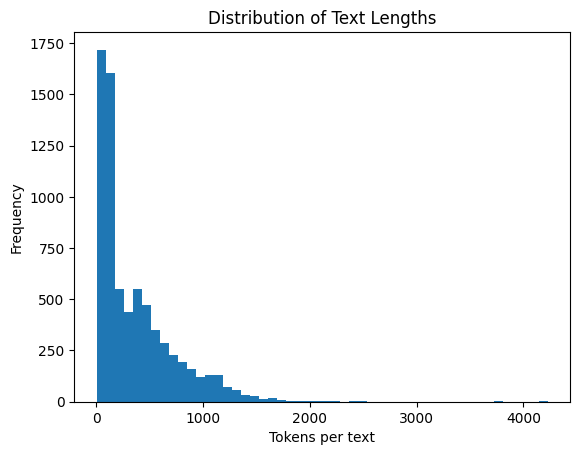

In [2]:
# Load preprocessed data
df = pd.read_csv('../data/raw/pre-processed.csv')
print(df.head())
print(df['label'].value_counts())

# Profile text lengths
df['len'] = df['preprocessed_news'].apply(lambda x: len(str(x).split()))
print(df['len'].describe())
print(df['len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))

# Optional: visualize length distribution
plt.hist(df['len'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Tokens per text")
plt.ylabel("Frequency")
plt.show()


### Stratified Train/Val/Test Split

In [3]:
# 70% train, 15% val, 15% test (stratified by label)
df_train, df_temp = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42
)

print("Train size:", len(df_train))
print("Val size:", len(df_val))
print("Test size:", len(df_test))

# Save splits (optional, or just use in memory)
df_train.to_csv('../data/processed/train.csv', index=False)
df_val.to_csv('../data/processed/val.csv', index=False)
df_test.to_csv('../data/processed/test.csv', index=False)


Train size: 5040
Val size: 1080
Test size: 1080


### Stratified Train/Val/Test Split

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Prepare data
X_train, y_train = df_train['preprocessed_news'], df_train['label']
X_val, y_val = df_val['preprocessed_news'], df_val['label']
X_test, y_test = df_test['preprocessed_news'], df_test['label']

# TF-IDF Vectorizer (fit only on train!)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_val_vec = tfidf.transform(X_val)
X_test_vec = tfidf.transform(X_test)

# Logistic Regression baseline
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_vec, y_train)

# Evaluate
print("Validation Metrics:")
val_pred = clf.predict(X_val_vec)
print(classification_report(y_val, val_pred))

print("Test Metrics:")
test_pred = clf.predict(X_test_vec)
print(classification_report(y_test, test_pred))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred))


Validation Metrics:
              precision    recall  f1-score   support

        fake       0.94      0.97      0.96       540
        true       0.97      0.94      0.95       540

    accuracy                           0.96      1080
   macro avg       0.96      0.96      0.96      1080
weighted avg       0.96      0.96      0.96      1080

Test Metrics:
              precision    recall  f1-score   support

        fake       0.93      0.97      0.95       540
        true       0.97      0.93      0.95       540

    accuracy                           0.95      1080
   macro avg       0.95      0.95      0.95      1080
weighted avg       0.95      0.95      0.95      1080

Confusion Matrix (Test):
[[525  15]
 [ 37 503]]


### Embedding Extraction Function (Reusable for Both BERTs)

In [5]:
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

def get_embeddings_batch(texts, model, tokenizer, batch_size=8, max_len=512, device='cpu'):
    embeddings = []
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            encodings = tokenizer(batch_texts,
                                  return_tensors='pt',
                                  padding=True,
                                  truncation=True,
                                  max_length=max_len)
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # CLS token for each sequence
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings


### Embedding Extraction Function (Reusable for Both BERTs)

In [6]:
# BERT-base-uncased (English baseline)
tokenizer_en = BertTokenizer.from_pretrained('bert-base-uncased')
model_en = BertModel.from_pretrained('bert-base-uncased').to(device)

X_train_en = df_train['preprocessed_news'].tolist()
X_val_en = df_val['preprocessed_news'].tolist()
X_test_en = df_test['preprocessed_news'].tolist()

# Embeddings (this will take time, consider batch_size=8 or 16 for large texts)
emb_train_en = get_embeddings_batch(X_train_en, model_en, tokenizer_en, batch_size=8, max_len=512, device=device)
emb_val_en = get_embeddings_batch(X_val_en, model_en, tokenizer_en, batch_size=8, max_len=512, device=device)
emb_test_en = get_embeddings_batch(X_test_en, model_en, tokenizer_en, batch_size=8, max_len=512, device=device)

np.save('../outputs/emb_train_en.npy', emb_train_en)
np.save('../outputs/emb_val_en.npy', emb_val_en)
np.save('../outputs/emb_test_en.npy', emb_test_en)


100%|██████████| 135/135 [00:38<00:00,  3.54it/s]


### Extract and Save Embeddings – BERTimbau (Portuguese BERT)

In [7]:
# BERTimbau (Portuguese)
tokenizer_pt = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model_pt = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased').to(device)

X_train_pt = df_train['preprocessed_news'].tolist()
X_val_pt = df_val['preprocessed_news'].tolist()
X_test_pt = df_test['preprocessed_news'].tolist()

emb_train_pt = get_embeddings_batch(X_train_pt, model_pt, tokenizer_pt, batch_size=8, max_len=512, device=device)
emb_val_pt = get_embeddings_batch(X_val_pt, model_pt, tokenizer_pt, batch_size=8, max_len=512, device=device)
emb_test_pt = get_embeddings_batch(X_test_pt, model_pt, tokenizer_pt, batch_size=8, max_len=512, device=device)

np.save('../outputs/emb_train_pt.npy', emb_train_pt)
np.save('../outputs/emb_val_pt.npy', emb_val_pt)
np.save('../outputs/emb_test_pt.npy', emb_test_pt)

100%|██████████| 135/135 [00:35<00:00,  3.79it/s]


### Train Classifier on Embeddings (Reusable Function)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, model_name="Model"):
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    val_pred = clf.predict(X_val)
    val_report = classification_report(y_val, val_pred, output_dict=True)
    test_pred = clf.predict(X_test)
    test_report = classification_report(y_test, test_pred, output_dict=True)
    print(f"{model_name} - Test Metrics:")
    print(classification_report(y_test, test_pred))
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_pred))
    return clf, test_report


### Run Classifier on Each Set of Embeddings

In [9]:
# Prepare labels (already done above)
y_train = df_train['label'].values
y_val = df_val['label'].values
y_test = df_test['label'].values

# (Re)load embeddings as needed
emb_train_en = np.load('../outputs/emb_train_en.npy')
emb_val_en = np.load('../outputs/emb_val_en.npy')
emb_test_en = np.load('../outputs/emb_test_en.npy')

emb_train_pt = np.load('../outputs/emb_train_pt.npy')
emb_val_pt = np.load('../outputs/emb_val_pt.npy')
emb_test_pt = np.load('../outputs/emb_test_pt.npy')

# (Re)load TF-IDF features for test
X_train_vec = tfidf.transform(X_train)
X_val_vec = tfidf.transform(X_val)
X_test_vec = tfidf.transform(X_test)

# Train and evaluate all models
results = []

# TF-IDF + LR
_, report_tfidf = train_and_evaluate(X_train_vec, y_train, X_val_vec, y_val, X_test_vec, y_test, model_name="TF-IDF + LogisticRegression")
results.append({
    "Model": "TF-IDF + LogisticRegression",
    "F1-Score": report_tfidf['weighted avg']['f1-score'],
    "Accuracy": report_tfidf['accuracy'],
    "Precision": report_tfidf['weighted avg']['precision'],
    "Recall": report_tfidf['weighted avg']['recall']
})

# BERT-base-uncased + LR
clf_en, report_en = train_and_evaluate(emb_train_en, y_train, emb_val_en, y_val, emb_test_en, y_test, model_name="BERT-base-uncased + LR")
results.append({
    "Model": "BERT-base-uncased + LR",
    "F1-Score": report_en['weighted avg']['f1-score'],
    "Accuracy": report_en['accuracy'],
    "Precision": report_en['weighted avg']['precision'],
    "Recall": report_en['weighted avg']['recall']
})

# BERTimbau + LR
clf_pt, report_pt = train_and_evaluate(emb_train_pt, y_train, emb_val_pt, y_val, emb_test_pt, y_test, model_name="BERTimbau + LR")
results.append({
    "Model": "BERTimbau + LR",
    "F1-Score": report_pt['weighted avg']['f1-score'],
    "Accuracy": report_pt['accuracy'],
    "Precision": report_pt['weighted avg']['precision'],
    "Recall": report_pt['weighted avg']['recall']
})

results_df = pd.DataFrame(results)
display(results_df)


TF-IDF + LogisticRegression - Test Metrics:
              precision    recall  f1-score   support

        fake       0.93      0.97      0.95       540
        true       0.97      0.93      0.95       540

    accuracy                           0.95      1080
   macro avg       0.95      0.95      0.95      1080
weighted avg       0.95      0.95      0.95      1080

Confusion Matrix (Test):
[[525  15]
 [ 37 503]]
BERT-base-uncased + LR - Test Metrics:
              precision    recall  f1-score   support

        fake       0.96      0.90      0.93       540
        true       0.91      0.96      0.93       540

    accuracy                           0.93      1080
   macro avg       0.93      0.93      0.93      1080
weighted avg       0.93      0.93      0.93      1080

Confusion Matrix (Test):
[[487  53]
 [ 21 519]]
BERTimbau + LR - Test Metrics:
              precision    recall  f1-score   support

        fake       0.97      0.95      0.96       540
        true       0.95    

,Model,F1-Score,Accuracy,Precision,Recall
0,TF-IDF + LogisticRegression,0.951832,0.951852,0.952603,0.951852
1,BERT-base-uncased + LR,0.931421,0.931481,0.933002,0.931481
2,BERTimbau + LR,0.959256,0.959259,0.959417,0.959259


### Results Table and Visualization

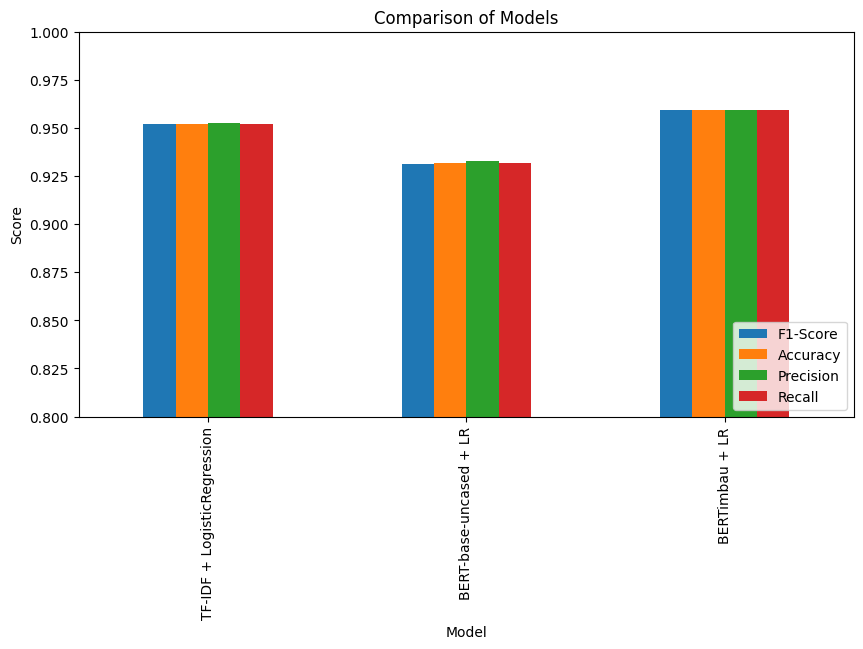

In [10]:
# Plot as before
results_df.plot(x="Model", y=["F1-Score", "Accuracy", "Precision", "Recall"], kind="bar", figsize=(10,5))
plt.ylabel("Score")
plt.title("Comparison of Models")
plt.ylim(0.8,1.0)
plt.legend(loc="lower right")
plt.show()

## New dataset to compare the original training

In [11]:
import pandas as pd

# Load a few rows from each file to check columns
df_fake = pd.read_csv('../data/raw/fakes.csv')
df_true = pd.read_csv('../data/raw/true.csv')

print("Fake news columns:", df_fake.columns)
print(df_fake.head(2))
print("True news columns:", df_true.columns)
print(df_true.head(2))


Fake news columns: Index(['title', 'text', 'origin', 'url', 'label', 'publisher_name',
       'publisher_site', 'date'],
      dtype='object')
                                               title  \
0  Vídeo com vaias a Nando Reis teve áudio manipu...   
1  Documentos confirmam uso de dinheiro vivo na c...   

                                                text           origin  \
0           “Nando Reis se F… Se F…. no Rock in Rio”           pessoa   
1  “Não foi dinheiro vivo. Moeda corrente, quer d...  Cristina Graeml   

                                                 url  label publisher_name  \
0  https://lupa.uol.com.br/jornalismo/2022/09/09/...      1     Lupa - UOL   
1  https://lupa.uol.com.br/jornalismo/2022/09/09/...      1     Lupa - UOL   

    publisher_site                  date  
0  lupa.uol.com.br                   NaN  
1  lupa.uol.com.br  2022-09-06T00:00:00Z  
True news columns: Index(['title', 'text', 'origin', 'url', 'label', 'publisher_name',
       'publisher

### Merging both datasets

In [12]:
# Suppose the main text column is "text" in both (adjust as needed after inspection)
main_text_col = 'text'  # or 'content', 'title', etc.

df_fake['label'] = 'fake'
df_true['label'] = 'true'

# Select only relevant columns: main_text_col and label
df_fake = df_fake[[main_text_col, 'label']]
df_true = df_true[[main_text_col, 'label']]

# Rename the text column to match your existing dataset (e.g., 'preprocessed_news')
df_fake = df_fake.rename(columns={main_text_col: 'preprocessed_news'})
df_true = df_true.rename(columns={main_text_col: 'preprocessed_news'})

# Merge both into a single DataFrame
df_test = pd.concat([df_fake, df_true], ignore_index=True)
print(df_test['label'].value_counts())
print(df_test.head())


label
fake    20478
true     2720
Name: count, dtype: int64
                                   preprocessed_news label
0           “Nando Reis se F… Se F…. no Rock in Rio”  fake
1  “Não foi dinheiro vivo. Moeda corrente, quer d...  fake
2  “Em seus últimos momentos de vida, rainha Eliz...  fake
3  “TSE MARCOU PARA PRÓXIMA SEMANA JULGAMENTO OND...  fake
4  De repente, a Ivermectina aparece no site do N...  fake


### Testing the trained models

In [13]:
# Transform the new test set using your existing TF-IDF vectorizer
X_test_vec = tfidf.transform(df_test['preprocessed_news'])

# Predict using your already-trained classifier
y_pred_tfidf = clf.predict(X_test_vec)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print("TF-IDF + LR results on Kaggle FakeNews Test Set:")
print(classification_report(df_test['label'], y_pred_tfidf))
print("Confusion Matrix:")
print(confusion_matrix(df_test['label'], y_pred_tfidf))


TF-IDF + LR results on Kaggle FakeNews Test Set:
              precision    recall  f1-score   support

        fake       0.88      1.00      0.94     20478
        true       0.00      0.00      0.00      2720

    accuracy                           0.88     23198
   macro avg       0.44      0.50      0.47     23198
weighted avg       0.78      0.88      0.83     23198

Confusion Matrix:
[[20471     7]
 [ 2720     0]]


In [14]:
# Para BERT-base-uncased
emb_test_en = get_embeddings_batch(
    df_test['preprocessed_news'].tolist(),
    model_en, tokenizer_en, batch_size=8, max_len=512, device=device
)

# Para BERTimbau
emb_test_pt = get_embeddings_batch(
    df_test['preprocessed_news'].tolist(),
    model_pt, tokenizer_pt, batch_size=8, max_len=512, device=device
)


100%|██████████| 2900/2900 [01:26<00:00, 33.67it/s]


In [15]:
# Previsões
y_pred_bert = clf_en.predict(emb_test_en)
y_pred_bertimbau = clf_pt.predict(emb_test_pt)


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

print("BERT-base-uncased + LR results on Kaggle FakeNews Test Set:")
print(classification_report(df_test['label'], y_pred_bert))
print("Confusion Matrix:")
print(confusion_matrix(df_test['label'], y_pred_bert))

print("\nBERTimbau + LR results on Kaggle FakeNews Test Set:")
print(classification_report(df_test['label'], y_pred_bertimbau))
print("Confusion Matrix:")
print(confusion_matrix(df_test['label'], y_pred_bertimbau))


BERT-base-uncased + LR results on Kaggle FakeNews Test Set:
              precision    recall  f1-score   support

        fake       0.88      1.00      0.94     20478
        true       0.14      0.00      0.00      2720

    accuracy                           0.88     23198
   macro avg       0.51      0.50      0.47     23198
weighted avg       0.80      0.88      0.83     23198

Confusion Matrix:
[[20472     6]
 [ 2719     1]]

BERTimbau + LR results on Kaggle FakeNews Test Set:
              precision    recall  f1-score   support

        fake       0.88      1.00      0.94     20478
        true       0.13      0.01      0.01      2720

    accuracy                           0.88     23198
   macro avg       0.51      0.50      0.47     23198
weighted avg       0.79      0.88      0.83     23198

Confusion Matrix:
[[20380    98]
 [ 2705    15]]
